In [58]:
#  import  data
import  numpy  as  np
import  pandas  as  pd
import  datetime
from sklearn import metrics
import warnings
import matplotlib.pyplot as plt
%matplotlib inline 

warnings.filterwarnings('ignore')
dfoff  =  pd.read_csv('train_offline.csv')
dftest  =  pd.read_csv('test_offline.csv')
dftotal = pd.concat([dfoff, dftest], axis = 0)

In [59]:
# Dealing with Distance
DistanceUM = dftotal.groupby(['User_id','Merchant_id'])['Distance'].mean().reset_index()
DistanceUM.columns = ['User_id','Merchant_id','DistanceUM']
DistanceU = dftotal.groupby(['User_id'])['Distance'].mean().reset_index()
DistanceU.columns = ['User_id','DistanceU']
DistanceM = dftotal.groupby(['Merchant_id'])['Distance'].mean().reset_index()
DistanceM.columns = ['Merchant_id','DistanceM']

dftotal = pd.merge(dftotal, DistanceUM,on = ['User_id','Merchant_id'], how = 'left')
dftotal = pd.merge(dftotal, DistanceU,on = ['User_id'], how = 'left')
dftotal = pd.merge(dftotal, DistanceM,on = ['Merchant_id'], how = 'left')
dftotal.head()

,Coupon_id,Date,Date_received,Discount_rate,Distance,Merchant_id,User_id,DistanceUM,DistanceU,DistanceM
0,NaN,20160217.0,NaN,NaN,0.0,2632,1439408,0.0,0.142857,1.540000
1,8591.0,NaN,20160217.0,20:1,0.0,2632,1439408,0.0,0.142857,1.540000
2,1078.0,NaN,20160319.0,20:1,0.0,2632,1439408,0.0,0.142857,1.540000
3,7610.0,NaN,20160429.0,200:20,0.0,3381,1832624,0.0,0.000000,2.713991
4,11951.0,NaN,20160129.0,200:20,1.0,3381,2029232,1.0,0.200000,2.713991


In [60]:
# Missing of Distance
def DistanceFillna(row):
    if np.isnan(row['Distance']):
        if not np.isnan(row['DistanceUM']):
            return int(row['DistanceUM'])
        elif not np.isnan(row['DistanceU']):
            return int(row['DistanceU'])
        elif not np.isnan(row['DistanceM']):
            return int(row['DistanceM'])
    return row['Distance']
dftotal['Distance'] = dftotal.apply(DistanceFillna, axis = 1)

In [61]:
# Create feature (Week_day)
def getWeekday(row):
    if np.isnan(row):
        return row
    else:
        return pd.to_datetime(row, format = '%Y%m%d').dayofweek+1
    
dftotal['weekday'] = dftotal['Date_received'].apply(getWeekday)

dftotal['weekend'] = dftotal['weekday'].apply(lambda x : 1 if x in [6,7] else 0 )

dftotal['Month_received'] = dftotal['Date_received'].apply(lambda x : datetime.datetime.strftime(pd.to_datetime(x, format =  '%Y%m%d'),"%m") 
                                                                                                if not np.isnan(x) else x)
dftotal['Day_received'] = dftotal['Date_received'].apply(lambda x : datetime.datetime.strftime(pd.to_datetime(x, format =  '%Y%m%d'),"%d")
                                                                                              if not np.isnan(x) else x)

In [62]:
# Record the total days to June
def set2June(df):
    if not pd.isnull(df['Month_received']):
        if int(df['Month_received']) < 6:
            return (6-int(df['Month_received']))*30 - int(df['Day_received'])
        else:
            return 1
    else:
        return np.nan
        
dftotal['CloseToJune'] = dftotal.apply(set2June, axis = 1)

In [63]:
# Dummy_var of weekday
weekdaycols = ['weekday_' + str(i) for i in range(1,8)]
print(weekdaycols)

tmpdf = pd.get_dummies(dftotal['weekday'])
tmpdf.columns = weekdaycols
dftotal[weekdaycols] = tmpdf

['weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'weekday_7']


In [64]:
# deal with discount_rate
def DiscountType(row):
    if not pd.isnull(row):
        if ':' in row:
            return 1
        else:
            return 0
    else:
        return row
def ConvertRate(row):
    if not pd.isnull(row):
        if ':' in row:
            split = row.split(':')
            return 1.0 - float(split[1]) / float(split[0])
        else:
            return float(row)
    else:
        return row
def GetDiscountMan(row):
    if not pd.isnull(row):
        if ':' in row:
            split = row.split(':')
            return split[0]
        else:
            return 0
    else:
        return row
def GetDiscountJian(row):
    if not pd.isnull(row):
        if ':' in row:
            split = row.split(':')
            return split[1]
        else:
            return 0
    else:
        return row
def preprocessing(df):
    #convert discount_rate
    df['discount_rate'] = df['Discount_rate'].apply(ConvertRate)
    df['discount_type'] = df['Discount_rate'].apply(DiscountType)
    df['discount_Man'] = df['Discount_rate'].apply(GetDiscountMan)
    df['discount_Jian'] = df['Discount_rate'].apply(GetDiscountJian)
    #dael with distance
    df.Distance = df.Distance.fillna(round(df.Distance.mean(), 1))
    return df
dftotal = preprocessing(dftotal)

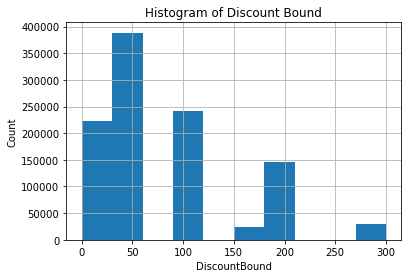

In [18]:
# Check the data distribution fitst
dftotal['DiscountBound'].hist()
plt.title('Histogram of Discount Bound')
plt.xlabel('DiscountBound')
plt.ylabel('Count')
plt.show()

In [65]:
# Discount bound group
cuttingArr = np.array([-1,80,150,250,301])
dftotal['DiscountBound'] = dftotal['discount_Man'].apply(lambda x: int(x) if not pd.isnull(x) else x )
dftotal['DirectPriceCut'] = dftotal['discount_Jian'].apply(lambda x: int(x) if not pd.isnull(x) else x )
dftotal['MoneyCost'] = dftotal['DiscountBound'] - dftotal['DirectPriceCut']
dftotal['DiscountBound_Group'] = pd.cut(dftotal.DiscountBound.fillna(np.nan), bins=cuttingArr,include_lowest=True)

print(dftotal.DiscountBound_Group.value_counts())
print('\n')

# encoding intervals into integer
DiscountBound_intervals = dftotal.DiscountBound_Group.unique()
dftotal.DiscountBound_Group.replace(to_replace = DiscountBound_intervals[0],value = -1, inplace = True)
dftotal.DiscountBound_Group.replace(to_replace = DiscountBound_intervals[1],value = 0, inplace = True)
dftotal.DiscountBound_Group.replace(to_replace = DiscountBound_intervals[2],value = 1, inplace = True)
dftotal.DiscountBound_Group.replace(to_replace = DiscountBound_intervals[3],value = 2, inplace = True)
dftotal.DiscountBound_Group.replace(to_replace = DiscountBound_intervals[4],value = 3, inplace = True)
print(dftotal.DiscountBound_Group.value_counts())

(-1.001, 80.0]    611276
(80.0, 150.0]     266140
(150.0, 250.0]    146602
(250.0, 301.0]     29264
Name: DiscountBound_Group, dtype: int64


-1    701602
 0    611276
 2    266140
 1    146602
 3     29264
Name: DiscountBound_Group, dtype: int64


### User ID related

In [66]:
# Same_Merchant_User_received
Same_Merchant_User_received = dftotal[['User_id','Merchant_id']]
Same_Merchant_User_received['temp'] = 1
Same_Merchant_User_received = Same_Merchant_User_received.groupby(['User_id','Merchant_id']).agg('sum').reset_index()
Same_Merchant_User_received.columns = ['User_id','Merchant_id','Same_Merchant_User_received']
dftotal = pd.merge(dftotal, Same_Merchant_User_received, on = ['User_id','Merchant_id'], how = 'left')

In [67]:
# Same_Coupon_User_received
Same_Coupon_User_received = dftotal[['User_id', 'Coupon_id']]
Same_Coupon_User_received['temp'] = 1
Same_Coupon_User_received = Same_Coupon_User_received.groupby(['User_id','Coupon_id']).agg('sum').reset_index()
Same_Coupon_User_received.columns = ['User_id','Coupon_id','Same_Coupon_User_received']

dftotal = pd.merge(dftotal,Same_Coupon_User_received , on = ['User_id', 'Coupon_id'], how = 'left')

In [68]:
# Same_Day_Same_Coupon_User_received
Same_Day_Same_Coupon_User_received = dftotal[['User_id','Coupon_id','Date_received']]
Same_Day_Same_Coupon_User_received['temp'] = 1
Same_Day_Same_Coupon_User_received = Same_Day_Same_Coupon_User_received.groupby(['User_id','Coupon_id','Date_received']).agg('sum').reset_index()
Same_Day_Same_Coupon_User_received.columns = ['User_id','Coupon_id','Date_received','Same_Day_Same_Coupon_User_received']

dftotal = pd.merge(dftotal, Same_Day_Same_Coupon_User_received , on = ['User_id','Coupon_id','Date_received'], how = 'left')

In [69]:
# Total_Coupon_User_received
Total_Coupon_User_received = dftotal.groupby(['User_id'])['Coupon_id'].count().reset_index()
Total_Coupon_User_received.columns = ['User_id', 'Total_Coupon_User_received']
dftotal = pd.merge(dftotal,Total_Coupon_User_received, on = ['User_id'], how = 'left')

In [70]:
# Same_Day_Total_Coupon_User_received
Same_Day_Total_Coupon_User_received = dftotal[['User_id','Date_received']]
Same_Day_Total_Coupon_User_received['temp'] = 1
Same_Day_Total_Coupon_User_received = Same_Day_Total_Coupon_User_received.groupby(['User_id','Date_received']).agg('sum').reset_index()
Same_Day_Total_Coupon_User_received.columns = ['User_id','Date_received', 'Same_Day_Total_Coupon_User_received']

dftotal = pd.merge(dftotal, Same_Day_Total_Coupon_User_received, on = ['User_id', 'Date_received'], how ='left')

In [71]:
# User_Received_Coupon_DiscountRatio_Mean
User_Received_Coupon_DiscountRatio_Mean = dftotal.groupby(['User_id'])['discount_rate'].mean().reset_index()
User_Received_Coupon_DiscountRatio_Mean.columns = ['User_id','User_Received_Coupon_DiscountRatio_Mean']
dftotal = pd.merge(dftotal,User_Received_Coupon_DiscountRatio_Mean, on = ['User_id'], how = 'left')

In [72]:
# Discount_Bound related
User_Received_Coupon_DistcountBound_Mean = dftotal.groupby(['User_id'])['DiscountBound'].mean().reset_index()
User_Received_Coupon_DistcountBound_Mean.columns = ['User_id','User_Received_Coupon_DistcountBound_Mean']

User_Received_Coupon_DistcountBound_Max = dftotal.groupby(['User_id'])['DiscountBound'].max().reset_index()
User_Received_Coupon_DistcountBound_Max.columns = ['User_id','User_Received_Coupon_DistcountBound_Max']

User_Received_Coupon_DistcountBound_Min = dftotal.groupby(['User_id'])['DiscountBound'].min().reset_index()
User_Received_Coupon_DistcountBound_Min.columns = ['User_id','User_Received_Coupon_DistcountBound_Min']

dftotal = pd.merge(dftotal,User_Received_Coupon_DistcountBound_Mean, on = ['User_id'], how = 'left')
dftotal = pd.merge(dftotal,User_Received_Coupon_DistcountBound_Max, on = ['User_id'], how = 'left')
dftotal = pd.merge(dftotal,User_Received_Coupon_DistcountBound_Min, on = ['User_id'], how = 'left')

In [73]:
# Money_Cost related
User_Received_Coupon_MoneyCost_Mean = dftotal.groupby(['User_id'])['MoneyCost'].mean().reset_index()
User_Received_Coupon_MoneyCost_Mean.columns = ['User_id','User_Received_Coupon_MoneyCost_Mean']

User_Received_Coupon_MoneyCost_Max = dftotal.groupby(['User_id'])['MoneyCost'].max().reset_index()
User_Received_Coupon_MoneyCost_Max.columns = ['User_id','User_Received_Coupon_MoneyCost_Max']

User_Received_Coupon_MoneyCost_Min = dftotal.groupby(['User_id'])['MoneyCost'].min().reset_index()
User_Received_Coupon_MoneyCost_Min.columns = ['User_id','User_Received_Coupon_MoneyCost_Min']

dftotal = pd.merge(dftotal,User_Received_Coupon_MoneyCost_Mean, on = ['User_id'], how = 'left')
dftotal = pd.merge(dftotal,User_Received_Coupon_MoneyCost_Max, on = ['User_id'], how = 'left')
dftotal = pd.merge(dftotal,User_Received_Coupon_MoneyCost_Min, on = ['User_id'], how = 'left')

### Merchant ID related

In [74]:
Merchant_DiscountRatio_max = dftotal.groupby(['Merchant_id'])['discount_rate'].max().reset_index()
Merchant_DiscountRatio_max.columns = ['Merchant_id','Merchant_DiscountRatio_max']

Merchant_DiscountRatio_min = dftotal.groupby(['Merchant_id'])['discount_rate'].min().reset_index()
Merchant_DiscountRatio_min.columns = ['Merchant_id','Merchant_DiscountRatio_min']

dftotal = pd.merge(dftotal,Merchant_DiscountRatio_max, on = ['Merchant_id'], how = 'left')
dftotal = pd.merge(dftotal,Merchant_DiscountRatio_min, on = ['Merchant_id'], how = 'left')

Mcount = dftotal.Merchant_id.value_counts().reset_index()
Mcount.columns = ['Merchant_id','Merchant_count']
Ccount = dftotal.Coupon_id.value_counts().reset_index()
Ccount.columns = ['Coupon_id','Coupon_count']

dftotal = pd.merge(dftotal,Mcount,on = ['Merchant_id'], how = 'left')
dftotal = pd.merge(dftotal,Ccount,on = ['Coupon_id'], how = 'left')

In [75]:
Merchant_DiscountBound_mean = dftotal.groupby(['Merchant_id'])['DiscountBound'].mean().reset_index()
Merchant_DiscountBound_mean.columns = ['Merchant_id','Merchant_DiscountBound_mean']
Merchant_DiscountBound_max = dftotal.groupby(['Merchant_id'])['DiscountBound'].max().reset_index()
Merchant_DiscountBound_max.columns = ['Merchant_id','Merchant_DiscountBound_max']
Merchant_DiscountBound_min = dftotal.groupby(['Merchant_id'])['DiscountBound'].min().reset_index()
Merchant_DiscountBound_min.columns = ['Merchant_id','Merchant_DiscountBound_min']
dftotal = pd.merge(dftotal,Merchant_DiscountBound_mean, on = ['Merchant_id'], how = 'left')
dftotal = pd.merge(dftotal,Merchant_DiscountBound_max, on = ['Merchant_id'], how = 'left')
dftotal = pd.merge(dftotal,Merchant_DiscountBound_min, on = ['Merchant_id'], how = 'left')

Merchant_DirectPriceCut_mean = dftotal.groupby(['Merchant_id'])['DirectPriceCut'].mean().reset_index()
Merchant_DirectPriceCut_mean.columns = ['Merchant_id', 'Merchant_DirectPriceCut_mean']
Merchant_DirectPriceCut_max = dftotal.groupby(['Merchant_id'])['DirectPriceCut'].max().reset_index()
Merchant_DirectPriceCut_max.columns = ['Merchant_id','Merchant_DirectPriceCut_max']
Merchant_DirectPriceCut_min = dftotal.groupby(['Merchant_id'])['DirectPriceCut'].min().reset_index()
Merchant_DirectPriceCut_min.columns = ['Merchant_id','Merchant_DirectPriceCut_min']
dftotal = pd.merge(dftotal,Merchant_DirectPriceCut_mean, on = ['Merchant_id'], how = 'left')
dftotal = pd.merge(dftotal,Merchant_DirectPriceCut_max, on = ['Merchant_id'], how = 'left')
dftotal = pd.merge(dftotal,Merchant_DirectPriceCut_min, on = ['Merchant_id'], how = 'left')

Merchant_MoneyCost_mean = dftotal.groupby(['Merchant_id'])['MoneyCost'].mean().reset_index()
Merchant_MoneyCost_mean.columns = ['Merchant_id', 'Merchant_MoneyCost_mean']
Merchant_MoneyCost_max = dftotal.groupby(['Merchant_id'])['MoneyCost'].max().reset_index()
Merchant_MoneyCost_max.columns = ['Merchant_id', 'Merchant_MoneyCost_max']
Merchant_MoneyCost_min = dftotal.groupby(['Merchant_id'])['MoneyCost'].min().reset_index()
Merchant_MoneyCost_min.columns = ['Merchant_id', 'Merchant_MoneyCost_min']
dftotal = pd.merge(dftotal,Merchant_MoneyCost_mean , on = ['Merchant_id'], how = 'left')
dftotal = pd.merge(dftotal,Merchant_MoneyCost_max, on = ['Merchant_id'], how = 'left')
dftotal = pd.merge(dftotal,Merchant_MoneyCost_min, on = ['Merchant_id'], how = 'left')

In [76]:
# Split the Data again
dfoff  =  dftotal[:len(dfoff)]
dftest  =  dftotal[len(dfoff):]

dfoff = dfoff[~dfoff.Coupon_id.isnull()]
dftest = dftest[~dftest.Coupon_id.isnull()]

dftest = dftest.drop(['Date'], axis = 1)

In [77]:
#  DateTime  processing
def  Get_Days(x,  y):
        if  not np.isnan(x):
                d1  =  pd.to_datetime(x, format =  '%Y%m%d')
                d2  =  pd.to_datetime(y, format =  '%Y%m%d')
                delta  =  d1 - d2
                return  delta.days
        else:
                return  np.nan
def  Tag(df):
        if not np.isnan(df['Date']):
                if  Get_Days(df['Date'],  df['Date_received'])  <=  15:
                        return  1
                else  :
                        return  0
        else  :
                return  0
#  Label  the  Coupon  Using  time
dfoff['Label']  =  dfoff.apply(Tag,  axis = 1)
dfoff['Label'].value_counts()

0    710665
1     36304
Name: Label, dtype: int64

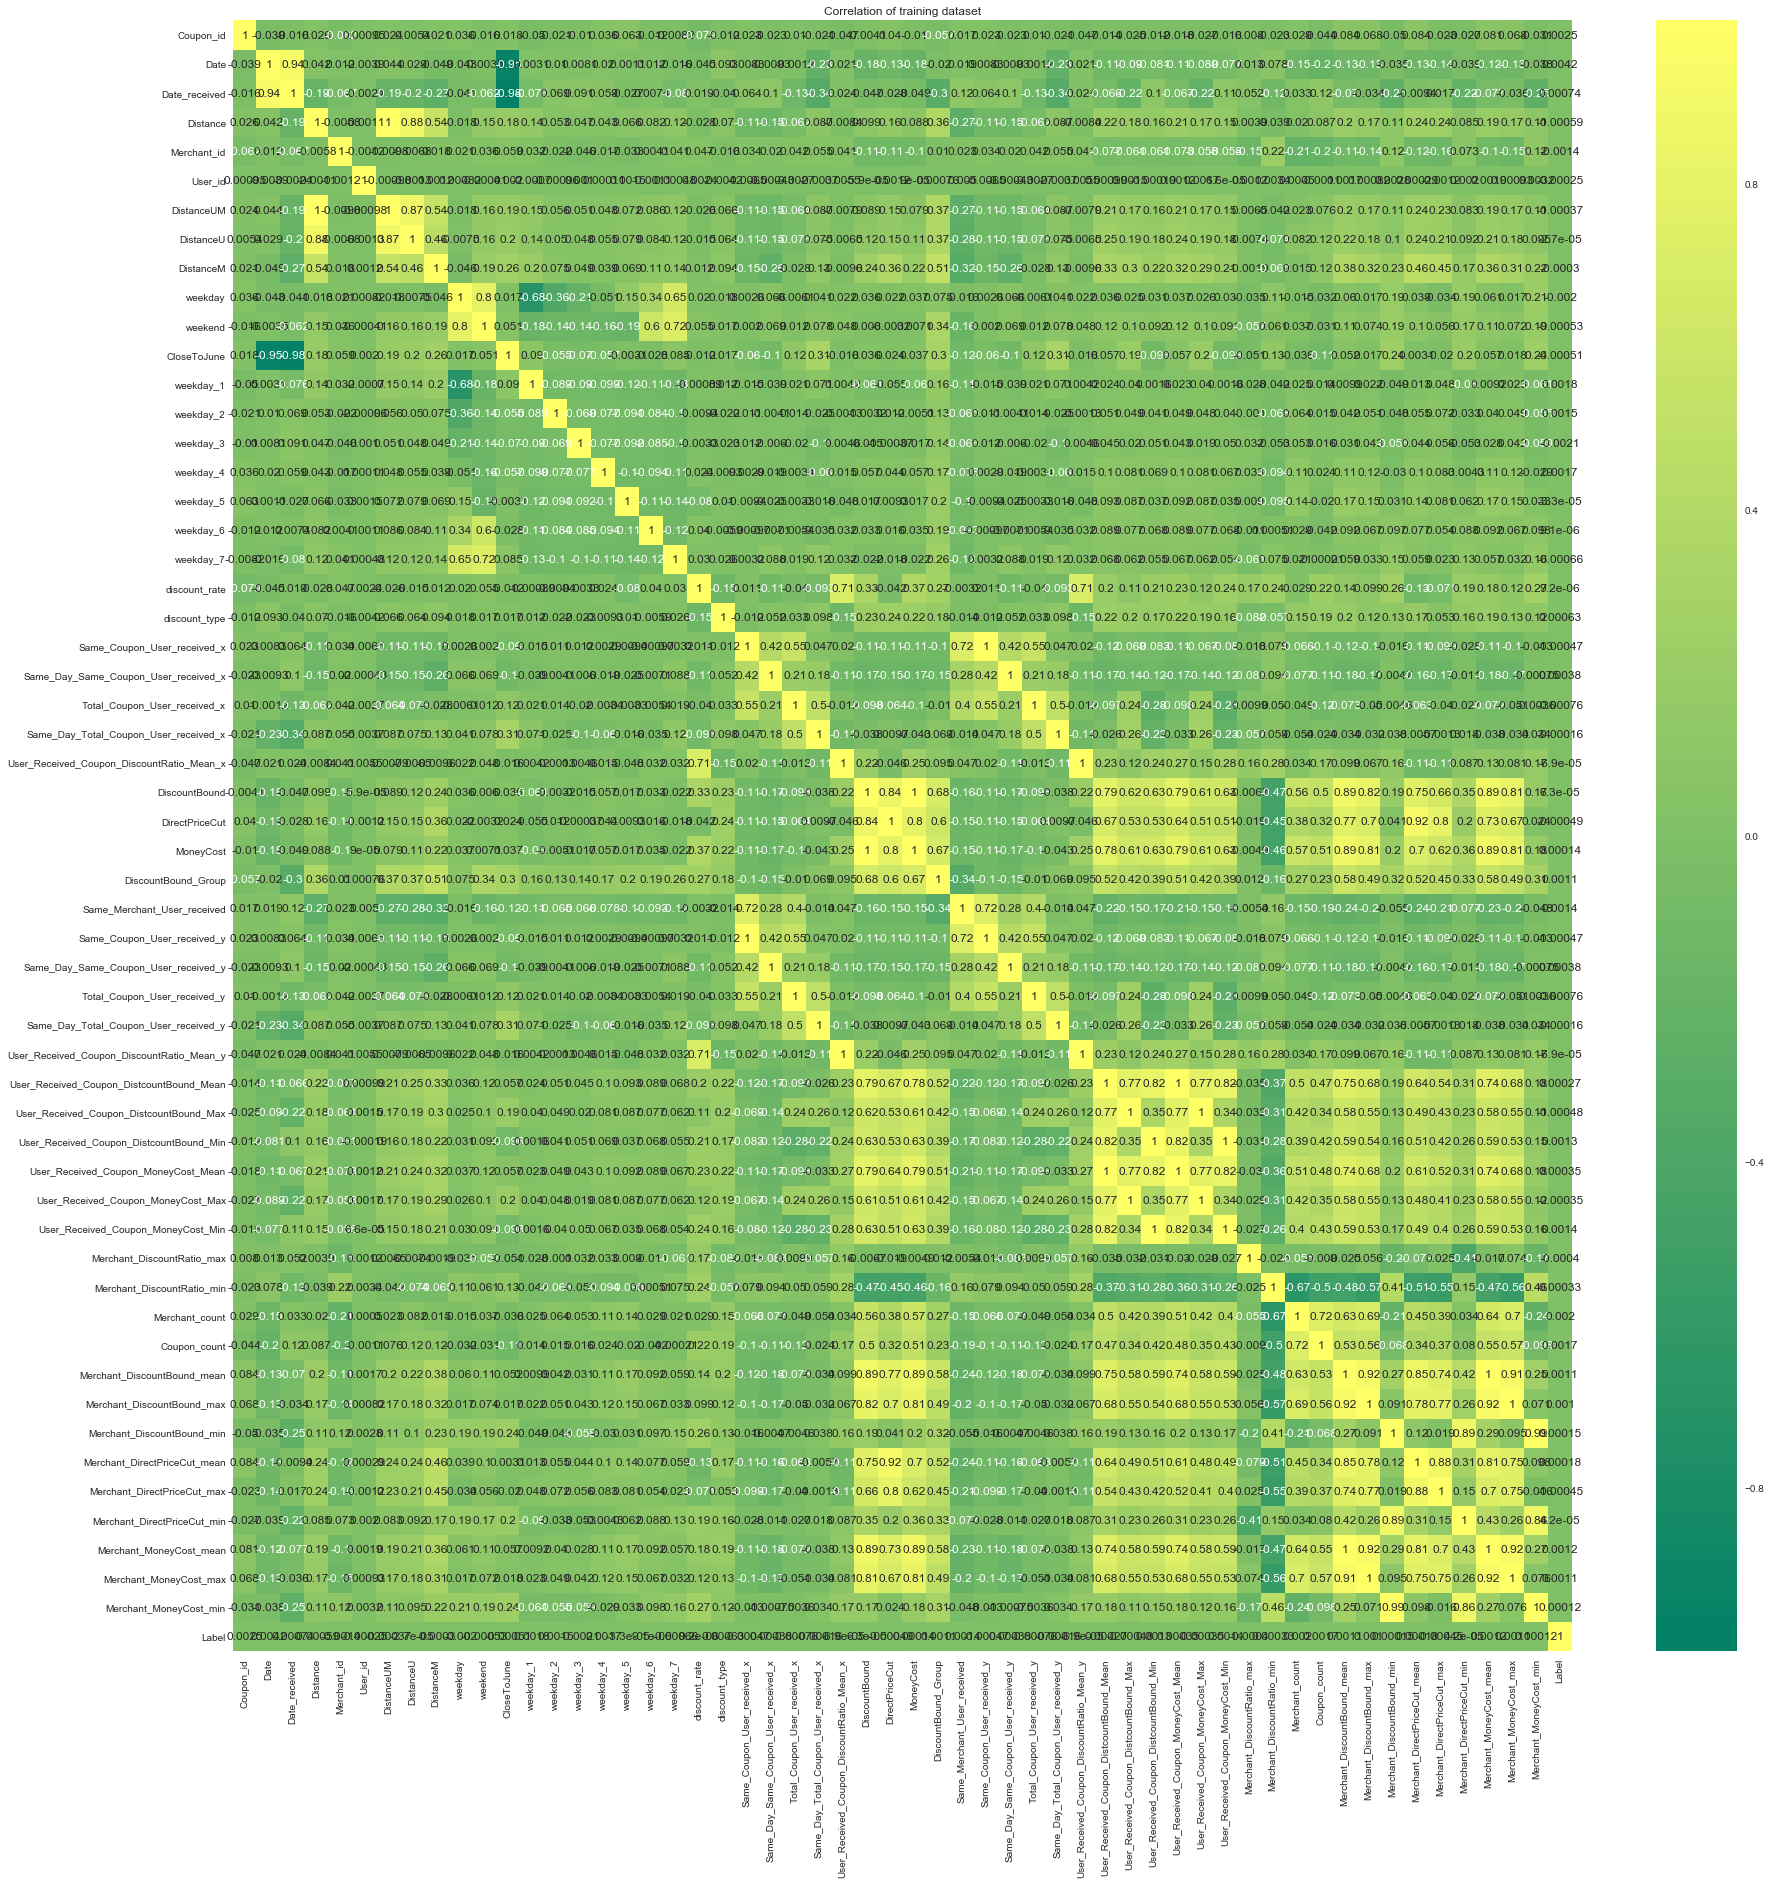

In [35]:
# Check the correlation again before fill the missing values of Distance
import copy
import seaborn as sns
correlation = copy.deepcopy(dftotal[:len(dfoff)])
correlation = pd.concat([correlation, pd.DataFrame(dfoff.Label.values, columns = ['Label'], index = correlation.index)], axis = 1)
corr = correlation.corr()
plt.figure(figsize = (30,30))
sns.heatmap(corr, cmap = plt.cm.summer, annot = True)
plt.title('Correlation of training dataset')
plt.show()

In [78]:
# Naive Model
df_y = dfoff['Label']
df_x = dfoff.drop(['Label'], axis = 1)

original_feature = ['discount_rate',
                    'discount_type',
                    'Distance', 
                    'weekday', 
                    'weekend',
                   'discount_Man',
                   'discount_Jian',
                    'MoneyCost',
                    'DiscountBound_Group',
                   'Month_received',
                   'Day_received',
                   'Same_Merchant_User_received',
                   'Same_Coupon_User_received',
                   'Same_Day_Same_Coupon_User_received',
                   'Total_Coupon_User_received',
                   'Same_Day_Total_Coupon_User_received',
                   'User_Received_Coupon_DiscountRatio_Mean',
                   'Merchant_DiscountRatio_max',
                   'Merchant_DiscountRatio_min',
                   'Merchant_count',
                   'Coupon_count',
                   'CloseToJune',
                   'User_Received_Coupon_DistcountBound_Mean',
                   'User_Received_Coupon_DistcountBound_Max',
                   'User_Received_Coupon_DistcountBound_Min',
                   'User_Received_Coupon_MoneyCost_Mean',
                   'User_Received_Coupon_MoneyCost_Max',
                   'User_Received_Coupon_MoneyCost_Min',
                   'Merchant_DiscountBound_mean',
                   'Merchant_DiscountBound_max',
                   'Merchant_DiscountBound_min',
                   'Merchant_DirectPriceCut_mean',
                   'Merchant_DirectPriceCut_max',
                   'Merchant_DirectPriceCut_min',
                   'Merchant_MoneyCost_mean',
                   'Merchant_MoneyCost_max',
                   'Merchant_MoneyCost_min'] + weekdaycols
print(len(original_feature),original_feature)

df_x = df_x[original_feature]
dftest_ = dftest[original_feature]

44 ['discount_rate', 'discount_type', 'Distance', 'weekday', 'weekend', 'discount_Man', 'discount_Jian', 'MoneyCost', 'DiscountBound_Group', 'Month_received', 'Day_received', 'Same_Merchant_User_received', 'Same_Coupon_User_received', 'Same_Day_Same_Coupon_User_received', 'Total_Coupon_User_received', 'Same_Day_Total_Coupon_User_received', 'User_Received_Coupon_DiscountRatio_Mean', 'Merchant_DiscountRatio_max', 'Merchant_DiscountRatio_min', 'Merchant_count', 'Coupon_count', 'CloseToJune', 'User_Received_Coupon_DistcountBound_Mean', 'User_Received_Coupon_DistcountBound_Max', 'User_Received_Coupon_DistcountBound_Min', 'User_Received_Coupon_MoneyCost_Mean', 'User_Received_Coupon_MoneyCost_Max', 'User_Received_Coupon_MoneyCost_Min', 'Merchant_DiscountBound_mean', 'Merchant_DiscountBound_max', 'Merchant_DiscountBound_min', 'Merchant_DirectPriceCut_mean', 'Merchant_DirectPriceCut_max', 'Merchant_DirectPriceCut_min', 'Merchant_MoneyCost_mean', 'Merchant_MoneyCost_max', 'Merchant_MoneyCost_min

In [79]:
# logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

logit_clf = LogisticRegression()
logit_clf.fit(df_x, df_y)
logit_pred = logit_clf.predict(df_x)

auc = metrics.roc_auc_score(df_y,  logit_pred)
cvs = cross_val_score(logit_clf, df_x, df_y, cv = 10).mean()
print('AUC : {:.2f}'.format(auc), 'CVS : {:.2f}'.format(cvs))

AUC : 0.52 CVS : 0.95


In [80]:
# reset_index
dftest_ = dftest_.reset_index(drop=True)
dftest = dftest.reset_index(drop=True)

In [88]:
# logistic regression submit
logit_pred_proba = logit_clf.predict_proba(dftest_)
sub = pd.concat((dftest[["User_id", "Coupon_id", "Date_received"]], pd.DataFrame(logit_pred_proba).iloc[:, 1]), axis=1)
sub.loc[:, "User_id"] = sub["User_id"].apply(lambda x:str(int(x)))
sub.loc[:, "Coupon_id"] = sub["Coupon_id"].apply(lambda x:str(int(x)))
sub.loc[:, "Date_received"] = sub["Date_received"].apply(lambda x:str(int(x)))
sub["uid"] = sub[["User_id", "Coupon_id", "Date_received"]].apply(lambda x: '_'.join(x.values), axis=1)
sub.reset_index(drop=True, inplace=True)

sub = sub.groupby("uid", as_index=False).mean()
sub = sub[["uid", 1]]
sub.columns = ["uid", "label"]
sub.to_csv('Coupon_logit.csv',  index=False)  

In [81]:
# Adaboost(logistic regression) submit
from sklearn.ensemble import AdaBoostClassifier
ada_logit = AdaBoostClassifier(base_estimator=logit_clf)
ada_logit.fit(df_x, df_y)
ada_logit_pred = ada_logit.predict(df_x)
print(metrics.roc_auc_score(df_y,  ada_logit_pred))

0.52386241243


In [ ]:
ada_logit_pred_proba = ada_logit.predict_proba(dftest) 
sub = pd.concat((sub["uid"], pd.DataFrame(ada_logit_pred_proba).iloc[:, 1]), axis=1)
sub = sub.groupby("uid", as_index=False).mean()
sub.columns = ["uid", "label"]
sub.to_csv('Coupon_ada_logit.csv',  index=False)

In [85]:
# Decision Tree submit
from sklearn.tree import DecisionTreeClassifier
DT_clf = DecisionTreeClassifier(random_state = 0, max_depth = 20)
DT_clf.fit(df_x, df_y)
DT_pred = DT_clf.predict(df_x)
print(metrics.roc_auc_score(df_y,  DT_pred))

0.816119051863


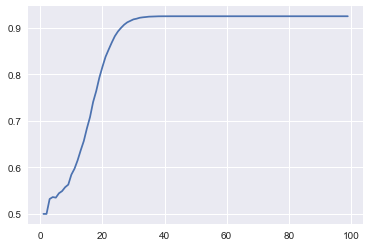

In [83]:
from sklearn.tree import DecisionTreeClassifier
x = []
y = []
for i in range(1,100):
    x.append(i)
    clf = DecisionTreeClassifier(random_state = 0, max_depth = i)
    clf.fit(df_x, df_y)
    DF_pred = clf.predict(df_x)
    y.append(metrics.roc_auc_score(df_y,  DF_pred))
plt.plot(x, y)

In [89]:
DT_pred_proba = DT_clf.predict_proba(dftest_)
sub = pd.concat((sub["uid"], pd.DataFrame(DT_pred_proba).iloc[:, 1]), axis=1)
sub = sub.groupby("uid", as_index=False).mean()
sub.columns = ["uid", "label"]
sub.to_csv('Coupon_DT.csv',  index=False) 

In [78]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
RF_clf = RandomForestClassifier(random_state = 0, max_depth = 60, n_estimators = 40)
RF_clf.fit(df_x, df_y)
RF_pred = RF_clf.predict(df_x)
print(metrics.roc_auc_score(df_y, RF_pred))

0.9245936227616368


In [ ]:
RF_pred_proba = RF_clf.predict_proba(dftest)
sub = pd.concat((sub["uid"], pd.DataFrame(RF_pred_proba).iloc[:, 1]), axis=1)
sub = sub.groupby("uid", as_index=False).mean()
sub.columns = ["uid", "label"]
sub.to_csv('Coupon_RF.csv',  index=False) 